In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [3]:
ner_df = pd.read_csv('/content/drive/My Drive/datasets/ner_dataset.csv', engine='python', na_values='NaN')

In [4]:
BATCHSIZE = 64
EPOCH = 10
LATENT_DIM = 100
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 10000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
MAXLEN = 100
EMBEDDING = MAX_SEQ_LEN

In [5]:
ner_df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [6]:
sentences_words = []
sentences_tags = []
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values: 
    if pd.notna(sent_num) and current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            current_sentence_words = []
            current_sentence_tags = []
    current_sentence_words.append(word)
    current_sentence_tags.append(tag)

In [7]:
vocab = set(itertools.chain.from_iterable(s for s in sentences_words)) 
tags = set(itertools.chain.from_iterable(s for s in sentences_tags))
sentenecs_lens = list(map(len, sentences_words))

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
words_tokenizer = Tokenizer(num_words=MAX_WORD_NUM)
words_tokenizer.fit_on_texts(sentences_words)
word_index = words_tokenizer.word_index
max_in_len = max(len(s) for s in sentences_words)
print(f"Number of input tokens: {len(word_index)}")
print(f"Maximum input sequence length: {max_in_len}")

Number of input tokens: 31811
Maximum input sequence length: 104


In [10]:
words_seq = words_tokenizer.texts_to_sequences(sentences_words)

In [11]:
words_seq_pad = pad_sequences(words_seq, maxlen=max_in_len)

In [12]:
tags_tokenizer = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tags_tokenizer.fit_on_texts(sentences_tags)
tag_index = tags_tokenizer.word_index
max_out_len = max(len(s) for s in sentences_tags)
out_word_num = len(tag_index) + 1
print(f"Number of output tokens: {len(tag_index)}")
print("Maximum output sequence length: {}".format(max_out_len))

Number of output tokens: 17
Maximum output sequence length: 104


In [13]:
tags_seq = tags_tokenizer.texts_to_sequences(sentences_tags)

In [14]:
tags_seq_pad = pad_sequences(tags_seq, maxlen=max_out_len)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [18]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_in_len,))
embedding_layer = TokenAndPositionEmbedding(max_in_len, len(vocab), embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(104, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [19]:
import keras.backend as K

In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model.compile("adam", loss=tf.keras.losses.Poisson(), metrics=["accuracy", recall_m, precision_m, f1_m])
history = model.fit(
    np.array(words_seq_pad[:38367]), np.array(tags_seq_pad[:38367]), batch_size=BATCHSIZE, epochs=EPOCH
)

Epoch 1/10
600/600 [==============================] - 50s 81ms/step - loss: 1.1714 - accuracy: 0.0540 - recall_m: 0.0063 - precision_m: 87933280.0000 - f1_m: 0.0127
Epoch 2/10
600/600 [==============================] - 49s 81ms/step - loss: 1.1105 - accuracy: 0.0689 - recall_m: 0.0077 - precision_m: 106449880.0000 - f1_m: 0.0153
Epoch 3/10
600/600 [==============================] - 50s 83ms/step - loss: 1.1033 - accuracy: 0.0750 - recall_m: 0.0076 - precision_m: 106199904.0000 - f1_m: 0.0153
Epoch 4/10
600/600 [==============================] - 50s 83ms/step - loss: 1.1006 - accuracy: 0.0767 - recall_m: 0.0077 - precision_m: 107333272.0000 - f1_m: 0.0155
Epoch 5/10
600/600 [==============================] - 49s 81ms/step - loss: 1.0987 - accuracy: 0.0820 - recall_m: 0.0080 - precision_m: 111283296.0000 - f1_m: 0.0160
Epoch 6/10
600/600 [==============================] - 50s 84ms/step - loss: 1.0966 - accuracy: 0.0900 - recall_m: 0.0087 - precision_m: 121583312.0000 - f1_m: 0.0175
Epoch

In [24]:
results = model.evaluate(np.array(words_seq_pad[38367:]), np.array(tags_seq_pad[38367:]), batch_size=BATCHSIZE)
print(results)

150/150 [==============================] - 4s 28ms/step - loss: 1.0912 - accuracy: 0.1148 - recall_m: 0.0128 - precision_m: 176533360.0000 - f1_m: 0.0256
[1.0911612510681152, 0.11479511857032776, 0.01280244067311287, 176533360.0, 0.02560488134622574]


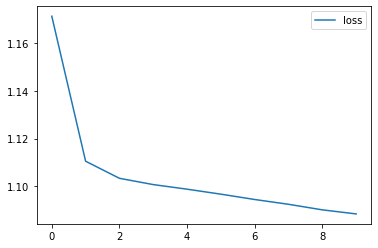

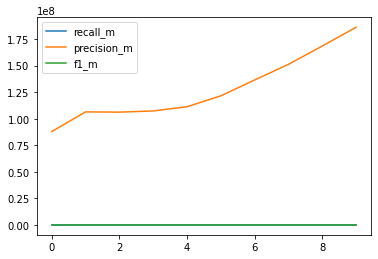

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

plt.plot(history.history['recall_m'], label='recall_m')
plt.plot(history.history['precision_m'], label='precision_m')
plt.plot(history.history['f1_m'], label='f1_m')
plt.legend()
plt.show()